# Real data experiments

We perform real data experiments on the Imagenet and MSCOCO datasets, for controlling risk metrics of various classifiers. These experiments have identical setup to the experiments in [Distribution-Free, Risk-Controlling Prediction Sets](https://arxiv.org/abs/2101.02703).

## Imagenet

Imagenet examples consist of an image $x \in \mathcal{X}$ that is paired with a single correct class $y \in \mathcal{Y}$.

Our loss is defined as follows for a label set $S$, and the corresponding true label $y$ is as follows:

$$ L(y, S) := L_y \mathbf{1}_{\left\{y \not\in S\right\}},$$

where $L_y \in \mathbb{R}^+$ denotes a user chosen penalty weight specifically for class $y$.

We can use a probabilistic classifier $\mathbf{p}: \mathcal{X} \mapsto \Delta^{|\mathcal{Y}|}$ to produce a probability distribution $\mathbf{p}(x)$ for each image $x$. For given features $x$, let $y_{(1)}, \dots, y_{(|\mathcal{Y}|)}$ be an ordering of labels from largest to smallest predicted probability $\mathbf{p}(x)_y$. Define $$i^* :=
\text{argmin}_{i \in [|\mathcal{Y}|]}\ \sum_{j \in [i]} \mathbf{p}(x)_{y_{(j)}} \geq \beta$$ where $\beta \in [0, 1]$ is the cutoff threshold for which labels to include in the label set. Then, we can define the corresponding label set as follows:
$$S(x) := \left\{y_{(1)}, \dots, y_{(i^*)}\right\}.$$

We directly work with $\mathbf{p}(x)$ generated using a ResNet512 classifier trained on Imagenet.

In [1]:
def load_data(data_dir):
    import load_data
    return load_data.load_imagenet_torch_preds(data_dir)

In [2]:
def predicted_risk(P, w, beta):
    import torch
    
    P, w = torch.Tensor(P), torch.Tensor(w)
    w_P = P * w.reshape(1, -1)
    w_P_sq = torch.square(P) * w.reshape(1, -1)
    sort_arr, idx_arr = torch.sort(w_P, descending=True, dim=-1, stable=True)


    sums_arr = torch.cumsum(sort_arr, dim=-1)
    top_idx = torch.argmax((sums_arr >= beta).int(), dim=-1)
    # if all sums are below beta, set to last possible index (i.e., include all labels)
    sum_small_idxs = torch.all(sums_arr < beta, dim=-1)
    top_idx[sum_small_idxs] = w.shape[0] - 1
        
    exc_sums = []
    for i in range(P.shape[0]):
        if top_idx[i] == w.shape[0] - 1:
            exc_sums.append(0)
        else:
            exc_idxs = idx_arr[i, (top_idx[i] + 1):]
            exc_sums.append(((w[exc_idxs] ** 2) * P[i, :][exc_idxs]).sum())
    return torch.Tensor(exc_sums).numpy()


def plot_imagenet_true_rho(scores, labels, betas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from tqdm.notebook import tqdm
    
    import scipy
    import seaborn as sns
    
    from Risk import TopBetaCoverage
    rng = np.random.default_rng(seed=322)
    
    weights = rng.uniform(size=scores.shape[1])

    rho = TopBetaCoverage()
    
    print(betas)
    
    risk_dists = [rho(((scores, None), labels), beta) for beta in tqdm(betas, 'Compute average risk')]
    fig, ax = plt.figure(figsize=(4, 4)), plt.gca()
    
    print(risk_dists[0].shape)
    df = pd.DataFrame({beta: risk_dist for beta, risk_dist in zip(betas, risk_dists)})
    new_df = df.melt(id_vars=[], value_vars=df.columns, var_name='$\\widehat{\\beta}$', value_name='risk')
    sns.histplot(data=new_df, hue='$\\widehat{\\beta}$', x='risk')
    
    risks = [np.mean(risk_dist) for risk_dist in risk_dists]
    print(risks)
    
    theta = 0.1
    def func(beta):
        return np.mean(rho(((scores, None), labels), beta)) - theta
    res = scipy.optimize.root_scalar(func, method='brentq', rtol=1e-4, bracket=(0, 1))
    assert res.converged, "Didn't converge"
    
    fig, ax = plt.figure(), plt.gca()
    ax.set_title(f"Imagenet ($\\theta={theta}, \\beta^* = {res.root:.4f}$)")
    
    ax.plot(betas, risks, label='True risk'), ax.set_xlabel('$\\beta$'), ax.set_ylabel('Miscoverage: $\\mathbb{E}[\\rho(X, Y, \\beta)]$')
    # ax.plot(betas, predicted_risks, label='Predicted risk')
    ax.legend()
    
    


[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


Compute average risk:   0%|          | 0/10 [00:00<?, ?it/s]

/datadrive/research/active-rc/suffix-cs/Risk.py:153: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  torch.Tensor([Y]).reshape(-1).int(),


(50000,)
[0.21672, 0.21514, 0.20976, 0.20046, 0.1849, 0.16084, 0.1371, 0.11094, 0.07696, 6e-05]


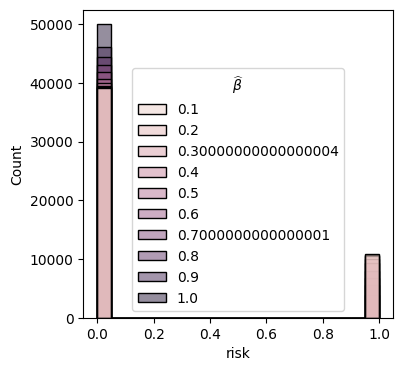

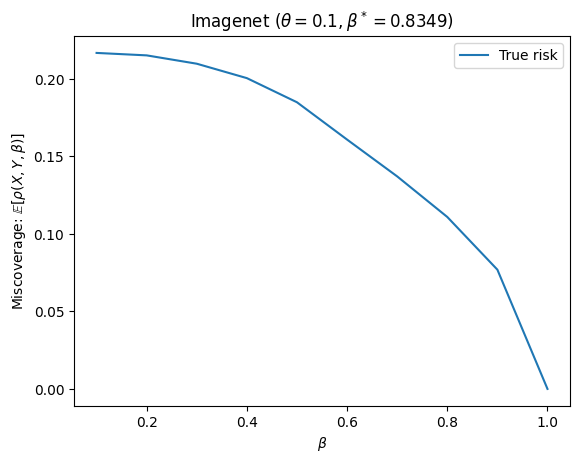

In [3]:
data_dir = 'data/imagenet_no_T'
scores, labels = load_data(data_dir)
def plot_fn():
    import numpy as np
    plot_imagenet_true_rho(scores, labels,betas=np.linspace(0.1, 1, 10))
plot_fn()

OK, so we can see from the histogram the risks are almost all 0! If nearly all risks are 0, that kinda defeats the point of doing any active learning at all really. So let's see what it is if we have a calibrated T.

In [4]:

def make_probe_data(test_beta, weights, margin, featurize):
    import torch
    Xs = []
    ps = []
    temp_weights = torch.ones(1000)
    for i in range(len(margin)):
        temp_p = torch.zeros(1000)
        temp_p[0] = test_beta + (1 - margin[i])
        temp_p[1] = margin[i]
        ps.append(temp_p.reshape(1, -1))
        Xs.append(featurize(temp_p.reshape(1, -1), weights, test_beta).reshape(1, -1))

    X = torch.concatenate(Xs)
    p = torch.concatenate(ps)
    return p, X

def probe(minimax, featurize, scores, labels, budget):
    import numpy as np
    import matplotlib.pyplot as plt
    import torch
    from Risk import TopBetaCoverage
    
    betas = np.arange(0.9, 1, 0.01)
    margins = np.arange(0.00, 0.11, 0.005) 
    probe_datas = [make_probe_data(beta, torch.ones(1000), margins, featurize) for beta in betas]
    results = []
    
    for probe_data in probe_datas:
        (Q, _), cons = minimax._primal_player.predict((probe_data, None))
        results.append(Q.detach().numpy())
    
    q_vals = np.array(results)
    tbc = TopBetaCoverage()
    cov_set = tbc.beta_coverage_set(torch.Tensor(scores), 0.9)
    miscovers = ~(cov_set[np.arange(cov_set.shape[0]), labels])
    est_miscovers = (torch.Tensor(scores) * (~(cov_set)).int()).sum(dim=-1).detach().numpy()
    
    fig, ax = plt.figure(), plt.gca()
    #for i in range(0, len(betas), 1):
    i = 0
    beta, q_val = betas[i], q_vals[i]
    max_margin = 1 - beta
    mask = margins <= max_margin
    ax.plot(margins[mask], q_val[mask], label=f"$\\beta={beta:.2f}$")
    twin_ax = ax.twinx()
    _, bins, _ = twin_ax.hist(est_miscovers, alpha=0.5, density=True)
    
    bin_indices = np.digitize(est_miscovers, bins)
    
    bin_miscovers = []
    for i in range(1, len(bins)):
        bin_miscovers.append(torch.mean(miscovers[bin_indices == i].float()).detach().item())
    print(bin_miscovers)
    ax.stairs(bin_miscovers, bins, color='red')
    
    twin_ax.set_ylabel('Freq. of est. margins across dataset')
    ax.axhline(budget, linestyle='dashed', color='gray')
    ax.set_xlabel('Est. miscoverage'), ax.set_ylabel('$q(x)')
    ax.set_title(f'# of labels: {minimax._primal_player._suml} ({minimax._primal_player._suml / len(scores)} of {len(scores)})')
    ax.legend()

In [5]:
# This experiment is correct out of the pre-computed results
# other experiment in the results/ dir had bugs and had incorrect performance
def load_debug_results(data_dir='results/imagenet_d/imagenet_w_cons_debug_01_'):
    import dill
    import pandas as pd
    import IwUpperMartingale
    from IwUpperMartingale import DummyMartingale
    import Player
    import os
    class DummyMinimax:
        def __init(self):
            pass
    class DummyPlayer:
        def __init(self):
            pass
    Player.DummyMinimax = DummyMinimax
    Player.DummyPlayer = DummyPlayer
    with open(f'{data_dir}/run_args.pkl', 'rb') as in_f:
        run_args = dill.load(in_f)
    
    #data_df = pd.read_csv(f'{data_dir}/last_beta_dist.csv')
    trial_result_dir = f'{data_dir}/trial_results'
    data_df = pd.concat([pd.read_csv(f'{trial_result_dir}/{path}') for path in os.listdir(trial_result_dir)])
    # return datas, data_df
    return run_args, data_df
# some_debug_df = load_debug_results()
# Results with overlapping std. error in bars in the real coverage of number of labels 
# means more trials need to be run

## visualization functions

In [6]:
import numpy as np
def mean_coverage_size(scores, beta, weights):
    from Risk import TopBetaCoverage
    tbc = TopBetaCoverage(w=weights)
    return tbc.beta_coverage_set(scores, beta).float().sum(dim=-1).mean().item()

def mean_threshold_coverage_size(scores, beta, weights):
    from Risk import WeightedCoverage
    tbc = WeightedCoverage(w=weights)
    return tbc.beta_coverage_set(scores, beta).float().sum(dim=-1).mean().item()

def in_fill_beta(sumls, betas, max_sumls):
    ext_pairs = []
    for i in range(len(sumls)):
        rg = range(int(sumls[i]), max_sumls + 1 if i == len(sumls) - 1 else int(sumls[i + 1]))
        ext_pairs.extend([(j, betas[i]) for j in rg])
    return ext_pairs
            
def visualize_beta_hat(run_args, beta_hat_df, scores, risk_fn=None, beta_star=None, in_fill_max=2000):
    import pandas as pd
    import seaborn as sns
    import torch
    import matplotlib.pyplot as plt
    from tqdm.notebook import tqdm
    
    print(f'Arguments of experiment: {run_args}\n')
    
    records = []
    
    torch_scores = torch.Tensor(scores)

    dpi_val = 100
    
    beta_hat_df = beta_hat_df.copy()
    # beta_hat_df['ACS'] = pd.Series([mean_coverage_size(torch_scores, beta, weights=None) \
    #                                 for beta in tqdm(beta_hat_df['$\\widehat{\\beta}$'])])
    
    max_label_ct = beta_hat_df['label_ct'].max()
    last_beta_df = beta_hat_df[beta_hat_df['label_ct'] == max_label_ct]
    if risk_fn is None:
        res = beta_hat_df[beta_hat_df['label_ct'] == max_label_ct] \
            .groupby(['Method'], as_index=False) \
            .agg({'$\\widehat{\\beta}$':['mean','std']})
        res.columns = res.columns.get_level_values(1)

        res = res.rename(columns=dict(zip(res.columns, ['Method', 'Mean', 'Std'])))
        res['Lower'] = res['Mean'] - (2 * res['Std'])
        res['Upper'] = res['Mean'] + (2 * res['Std'])

    
        res['ACS'] = [mean_coverage_size(torch_scores, beta, weights=None) for beta in tqdm(res['Mean'], leave=False)]
        res['ACS_lower'] = [mean_coverage_size(torch_scores, beta, weights=None) for beta in res['Lower']]
        res['ACS_upper'] = [mean_coverage_size(torch_scores, beta, weights=None) for beta in res['Upper']]
        res['ACS_center'] = (res['ACS_lower'] + res['ACS_upper']) / 2
        res['ACS_error'] = (res['ACS_upper'] - res['ACS_lower']) / 2
    
    else:
        avg_cov_fn = risk_fn.data_covsize_curve(torch_scores)
        res = beta_hat_df[beta_hat_df['label_ct'] == max_label_ct].copy()
        res['ACS'] = [avg_cov_fn(beta) for beta in res['$\\widehat{\\beta}$']]
        res = res.groupby(['Method'], as_index=False) \
            .agg({'$\\widehat{\\beta}$':['mean','std'],
                  'ACS': ['mean', 'std']})
        # res.columns = res.columns.get_level_values(1)
        res.columns = [' '.join(col).strip() for col in res.columns.values]

        res = res.rename(columns=dict(zip(res.columns, ['Method', 'Mean', 'Std', 'ACS_mean', 'ACS_std'])))
        print(res)
        res['ACS_center'] = res['ACS_mean']
        res['ACS_error'] = 1 * res['ACS_std']
    
    
    method_map = {
        'active (partial)': 'active\n($\\widehat{r}(x) = 0$)',
        'active (partial+cons_cv)': 'active\n($\\widehat{r}(x) = \\widehat{c}$)',
        'active (shifted)': 'active\n($\\widehat{r}(x) = 1$)',
        'oblivious (partial)': 'oblivious',
        'sample everything': 'sample all'
    }
    # res = res.replace({'Method': method_map})
    
    
    sns.set_theme()
    # label count vs. beta hat
    if len(set(beta_hat_df['label_ct'])) > 1:
        points = 21
        x_bins = np.linspace(0, max_label_ct, points)
        beta_hat_df['grid_x'] = x_bins[
            np.digitize(beta_hat_df['label_ct'].to_numpy(), x_bins, right=True)
        ]
            # .apply(lambda x: np.searchsorted(x_bins, x, side='left'))
        binned_df = beta_hat_df \
                    .sort_values('$\\widehat{\\beta}$') \
                    .groupby(['Method', 'grid_x', 'seed']).first() \
                    .reset_index()
                        

        fig, ax = plt.figure(figsize=(4,4), dpi=dpi_val), plt.gca()

        sns.lineplot(data=binned_df,
                      x='grid_x', 
                      y='$\\widehat{\\beta}$',
                      hue='Method',
                      # err_style='bars',
                      # errorbar=("se", 2),
                      # err_kws={"color": ".5", "linewidth": 1, 'solid_capstyle': 'round'},
                      ax=ax)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        if beta_star is not None:
            ax.axhline(beta_star, linestyle='dashed', color='gray')

        plt.xticks(rotation=90)
    
    # Method vs. actual prediction interval size
    plt.figure(figsize=(4,4), dpi=dpi_val)
    ax = plt.gca()
    res.plot(ax=ax, x='Method', y='ACS_center', kind="scatter")
    ax.errorbar(x=res['Method'], 
                y=res['ACS_center'], 
                yerr=res['ACS_error'], 
                capsize=4, color=".5", 
                linewidth=2.5, linestyle='none', 
                elinewidth=2)
    plt.xticks(rotation=90)

    # Method vs. beta hat
    fig, ax = plt.figure(figsize=(4,4), dpi=dpi_val), plt.gca()
    ax = sns.pointplot(data=last_beta_df,
                  x='Method', y='$\\widehat{\\beta}$', 
                  errorbar=("se", 2), capsize=.4,
                  err_kws={"color": ".5", "linewidth": 2.5},
                  linestyle='none',
                  ax=ax)
    
    if beta_star is not None:
        ax.axhline(beta_star, linestyle='dashed', color='gray')
        
    
    plt.xticks(rotation=90)
    
    # Histogram (of trials) of beta hat for each method
    fig, ax = plt.figure(figsize=(4,4), dpi=dpi_val), plt.gca()
    sns.histplot(data=last_beta_df,
                hue='Method', x='$\\widehat{\\beta}$', bins=20, ax=ax)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    if beta_star is not None:
        ax.axvline(beta_star, linestyle='dashed', color='gray')
    
    plt.xticks(rotation=90)


Arguments of experiment: {'data_dir': 'data/imagenet_no_T', 'out_dir': 'results/imagenet_d/new_exp_long', 'trials': 1000, 'label_ct': 3333, 'weight_path': None, 'weights': None}

                Method      Mean       Std  ACS_mean   ACS_std
0     active (shifted)  0.861565  0.013609  1.002278  0.000245
1  oblivious (partial)  0.862038  0.014010  1.002289  0.000252
2   pretrain (shifted)  0.854587  0.006716  1.002128  0.000121


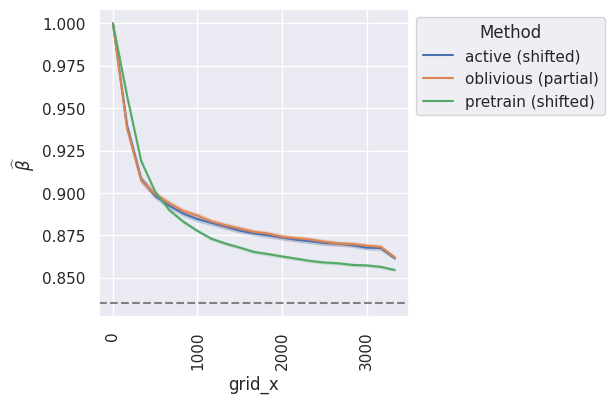

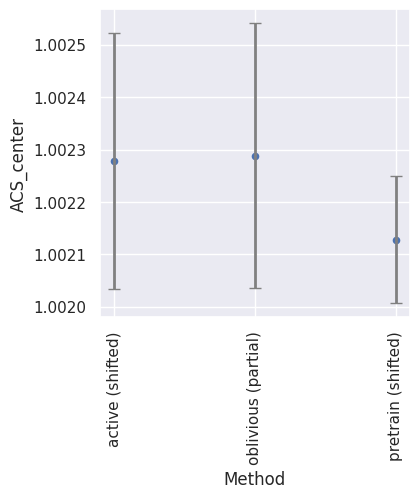

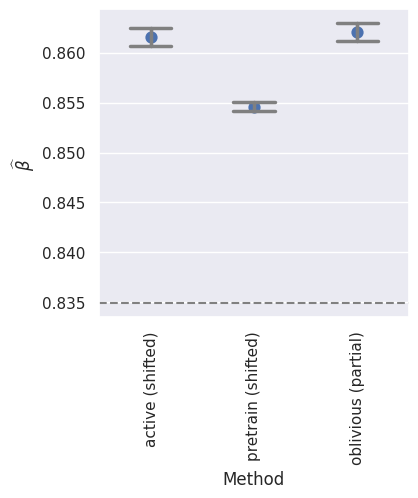

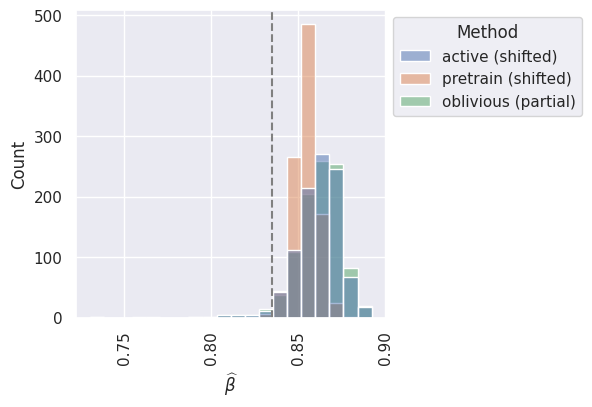

In [7]:
def plot():
    from Risk import TopBetaCoverage
    visualize_beta_hat(*(load_debug_results('results/imagenet_d/new_exp_long')), scores=scores, risk_fn=TopBetaCoverage(), \
                      beta_star=0.8349)
plot()

Arguments of experiment: {'data_dir': 'data/imagenet_no_T', 'out_dir': 'results/imagenet_d/new_exp_long_ablation', 'trials': 1000, 'label_ct': 3333, 'weight_path': None, 'weights': None}

                    Method      Mean       Std  ACS_mean   ACS_std
0            active (half)  0.862278  0.012188  1.002288  0.000232
1         active (partial)  0.861965  0.012256  1.002282  0.000232
2         active (shifted)  0.862130  0.018717  1.002302  0.000294
3           full (partial)  0.862121  0.012348  1.002285  0.000234
4      oblivious (learned)  0.862346  0.012855  1.002291  0.000240
5      oblivious (partial)  0.862463  0.012561  1.002293  0.000239
6     oblivious (pretrain)  0.862421  0.012527  1.002292  0.000238
7       pretrain (partial)  0.847617  0.003675  1.002002  0.000060
8  pretrain_var (pretrain)  0.849461  0.004659  1.002034  0.000078
9        sample everything  0.871352  0.022344  1.002528  0.000418


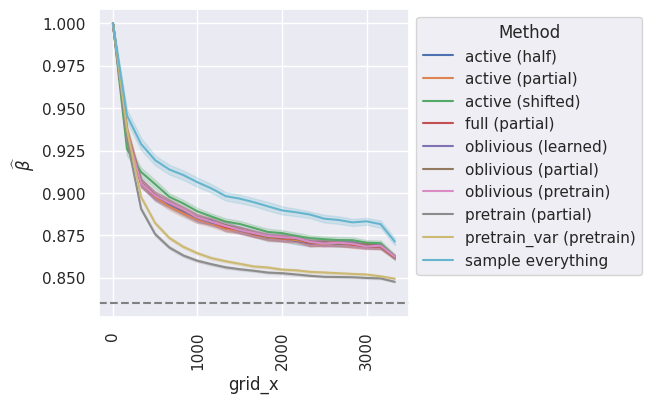

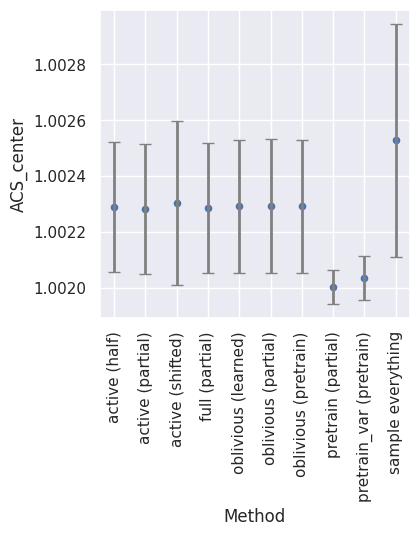

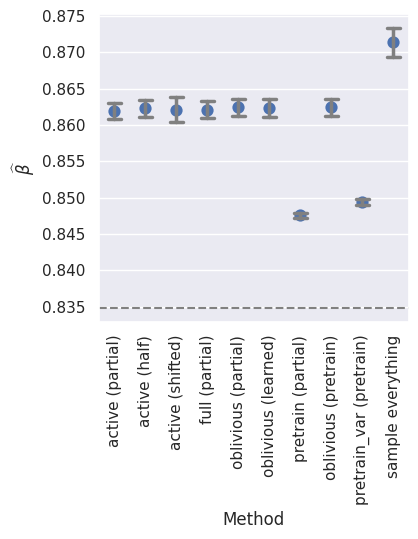

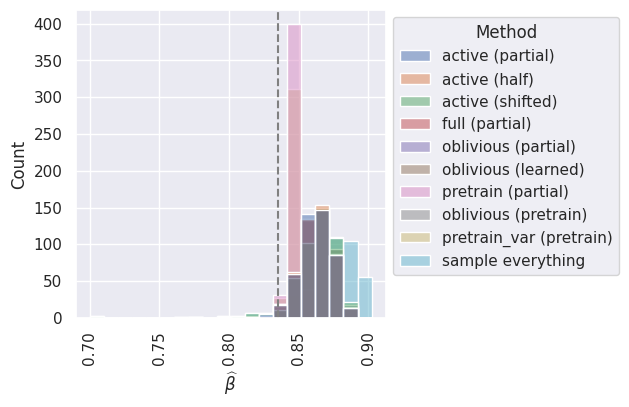

In [8]:
def plot():
    from Risk import TopBetaCoverage
    visualize_beta_hat(*(load_debug_results('results/imagenet_d/new_exp_long_ablation')), scores=scores, risk_fn=TopBetaCoverage(), \
                      beta_star=0.8349)
plot()

Arguments of experiment: {'data_dir': 'data/imagenet_no_T', 'out_dir': 'results/imagenet_v2/lc_3000', 'trial_start': 1, 'trials': 96, 'label_ct': 3000, 'weight_path': None, 'processes': 48, 'q_min': 0.1, 'theta': 0.1, 'target_rate': 0.3}



  0%|          | 0/4 [00:00<?, ?it/s]

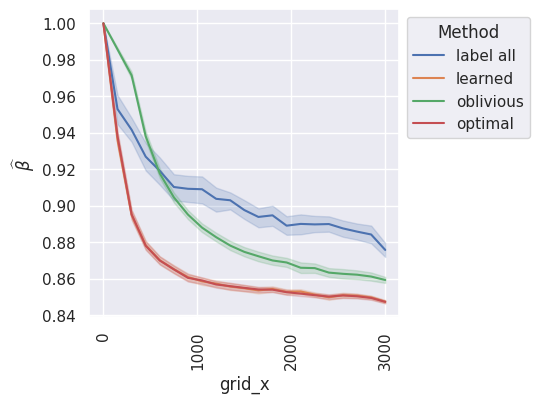

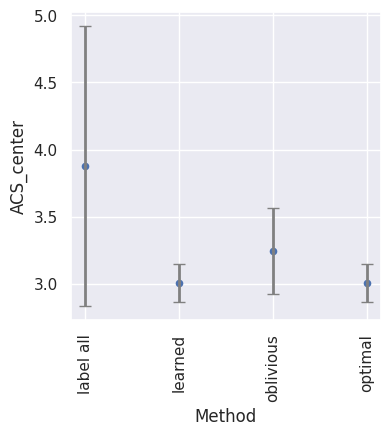

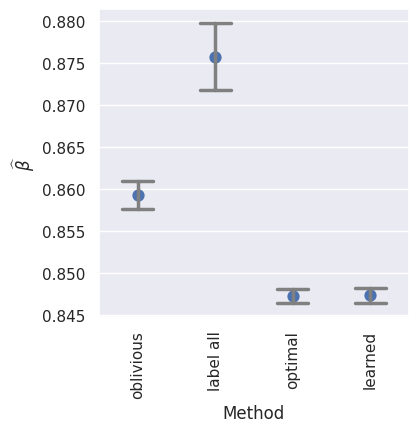

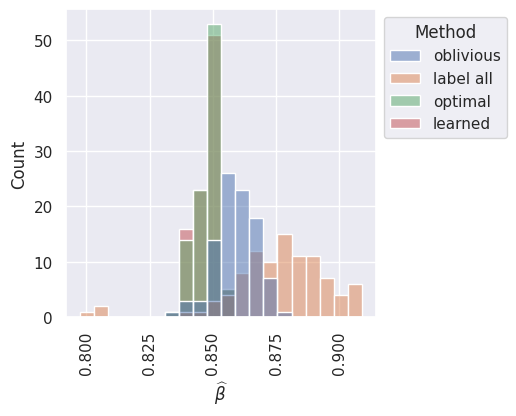

In [19]:
def plot():
    visualize_beta_hat(*(load_debug_results('results/imagenet_v2/lc_3000')), scores=scores, \
                      beta_star=None)
plot()

Arguments of experiment: {'data_dir': 'data/coco', 'out_dir': 'results/coco_d/new_exp_long_ablation', 'trials': 1000, 'label_ct': 800}



  0%|          | 0/10 [00:00<?, ?it/s]

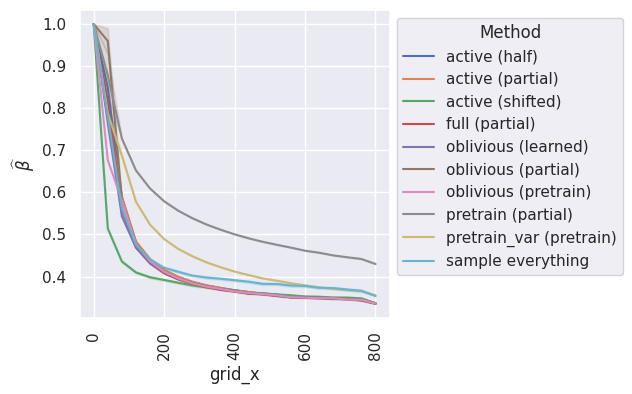

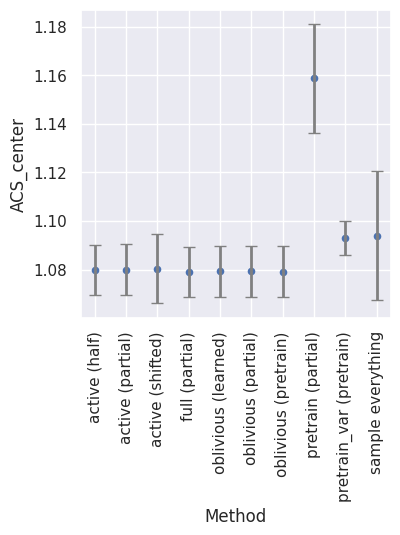

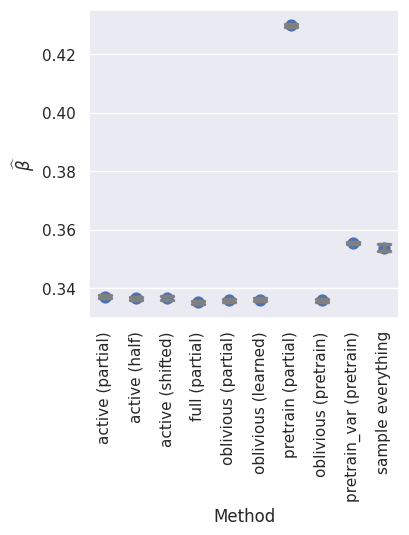

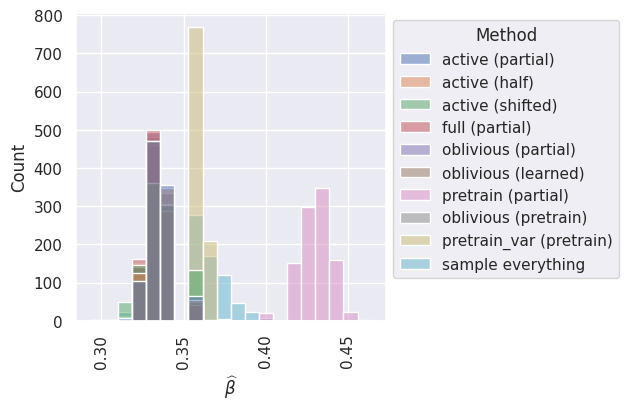

In [9]:
def plot():
    from Risk import NegRecall
    visualize_beta_hat(*(load_debug_results('results/coco_d/new_exp_long_ablation')), scores=scores, \
                      beta_star=None)
plot()

## COCO MS

COCOMS dataset is a multilabel classification dataset. Hence, examples consist of an image $x \in \mathcal{X}$ that is paired with a _vector_ of labels $\mathbf{y} \in 2^\mathcal{Y}$.

Our goal is is still to form a label set $S$, but now we are interested in computing the inverse of the recall as our loss:

$$ L(\mathbf{y}, S) := 1 - \frac{|\mathbf{y} \cap S|}{|\mathbf{y}|}.$$

We can use a probabilistic classifier $\mathbf{p}: \mathcal{X} \mapsto \Delta^{|\mathcal{Y}|}$ to produce a probability distribution $\mathbf{p}(x)$ for each image $x$. Then, we can define the corresponding label set as follows:
$$S(x) := \left\{y \in \mathcal{Y}: \mathbf{p}(x)_y \geq 1 - \beta \right\},$$
where $\beta \in [0, 1]$ is the cutoff threshold for which labels to include in the label set.

We directly work with $\mathbf{p}(x)$ generated using a ResNet512 classifier trained on Imagenet.

In [10]:
coco_data_dir = 'data/coco'
coco_scores, coco_labels = load_data(coco_data_dir)
coco_scores.shape, coco_labels.shape

((4952, 80), (4952, 80))

(4952,)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


average scores greater than 1 per example 0.0022213247172859453
average labels per example 2.9545638126009695
recall (threshold at 0.5) 0.9568024300910003
precision (threshold at 0.5) 0.6291280722699923
   beta  avg. neg. recall
0   0.1          0.199032
1   0.2          0.146337
2   0.3          0.105006
3   0.4          0.071560
4   0.5          0.043198
5   0.6          0.021318
6   0.7          0.008390
7   0.8          0.002225
8   0.9          0.000363
9   1.0          0.000000


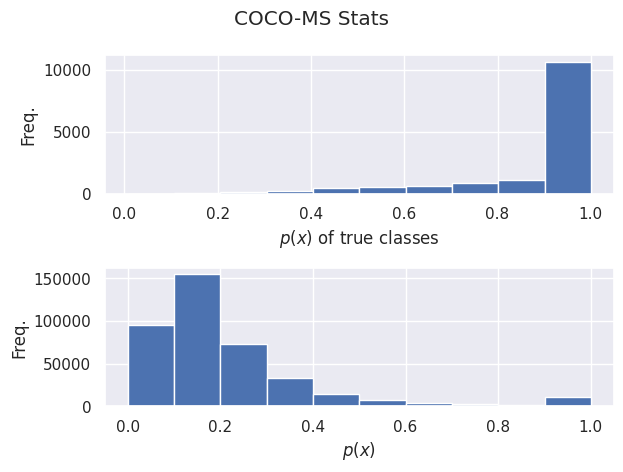

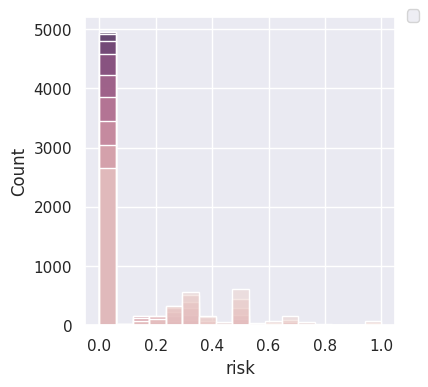

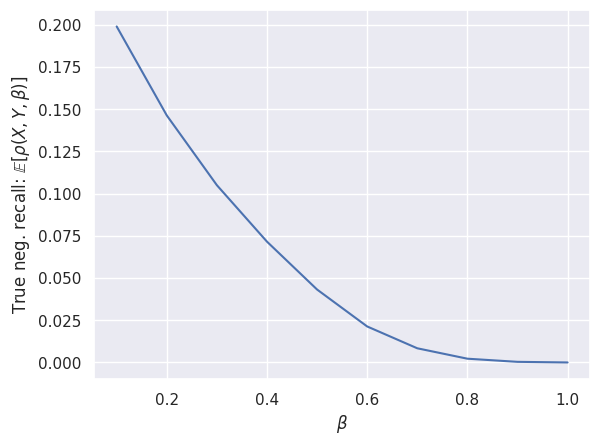

In [11]:
def plot_coco_true_rho(coco_scores, coco_labels):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import seaborn as sns
    from Risk import NegRecall
    
    
    rho = NegRecall()
    step = 0.1
    betas = np.arange(0.1, 1. + step, step)
    
    fig, axes = plt.subplots(2)    
    axes[0].hist(coco_scores[coco_labels.astype(bool)])
    axes[1].hist(coco_scores.reshape(-1))
    
    axes[0].set_xlabel('$p(x)$ of true classes'), axes[0].set_ylabel('Freq.')
    axes[1].set_xlabel('$p(x)$'), axes[1].set_ylabel('Freq.')
    fig.suptitle('COCO-MS Stats')
    fig.tight_layout()

    risk_dists = [rho(((coco_scores, None), coco_labels), beta) for beta in betas]
    fig, ax = plt.figure(figsize=(4, 4)), plt.gca()
    
    print(risk_dists[0].shape)
    df = pd.DataFrame({beta: risk_dist for beta, risk_dist in zip(betas, risk_dists)})
    new_df = df.melt(id_vars=[], value_vars=df.columns, var_name='$\\widehat{\\beta}$', value_name='risk')
    sns.histplot(data=new_df, hue='$\\widehat{\\beta}$', x='risk')
    ax.legend(bbox_to_anchor=(1.1, 1.05))

   
    risks = [np.mean(risk_dist) for risk_dist in risk_dists]


    fig, ax = plt.figure(), plt.gca()
    ax.plot(betas, risks), ax.set_xlabel('$\\beta$'), ax.set_ylabel('True neg. recall: $\\mathbb{E}[\\rho(X, Y, \\beta)]$')
    
    
    print('average scores greater than 1 per example', (coco_scores >= 1).sum(axis=-1).mean())
    print('average labels per example', coco_labels.sum(axis=-1).mean())
    print('recall (threshold at 0.5)', (((coco_scores >= 0.5) * coco_labels).sum(axis=-1) / coco_labels.sum(axis=-1)).mean())
    print('precision (threshold at 0.5)', (((coco_scores >= 0.5) * coco_labels).sum(axis=-1) / (coco_scores >= 0.5).sum(axis=-1)).mean())
    print(pd.DataFrame({'beta': betas, 'avg. neg. recall': risks}))

plot_coco_true_rho(coco_scores, coco_labels)

In [12]:
visualize_beta_hat(*(load_debug_results('results/coco_d/fbml_target_rate=0.6')))


TypeError: visualize_beta_hat() missing 1 required positional argument: 'scores'

In [ ]:
def load_coco_cv_results():
    import dill
    import os
    import re
    import pandas as pd
    import IwUpperMartingale
    from IwUpperMartingale import DummyMartingale
    import Player
    data_dir = 'results/coco_d/big_lam'
    trial_dir = f'{data_dir}/trial_results'
    print(f"Trial dir: {trial_dir}")
    data_df = pd.concat([pd.read_csv(f'{trial_dir}/{fname}') for fname in os.listdir(trial_dir) if re.fullmatch(r'.*\.csv', fname)], axis=0)
    print(data_df.columns)
    # with open(f'{data_dir}/result_dump.pkl', 'rb') as in_f:
    #    datas = dill.load(in_f)
    f_df = data_df.groupby('seed')['label_ct'].agg(['min', 'max'])
    print(f'Data length: {len(data_df)}')
    bad_seeds = f_df[f_df['min'] < 800].reset_index()['seed']
    print(f'Bad/incomplete seeds/trials: {len(bad_seeds)}')
    data_df = data_df[~(data_df['seed'].isin(bad_seeds))]
    print(f'Data length after rem. inc.: {len(data_df)}')
    # data_df = data_df[~(data_df['Method'].isin(['active (partial)', 'active (partial+q_cv)']))]
    return data_df
# visualize_beta_hat(load_debug_results('results/coco_d/fbml_target_rate=0.5'))
# visualize_beta_hat(load_debug_results('results/coco_d/fewer_dim_2'))
# visualize_beta_hat(load_debug_results('results/coco_d/fewer_beta_more_loss'))
# visualize_beta_hat(load_debug_results('results/coco_d/fewer_beta_more_loss_2'))

Strange that shifted does well on COCO but not on Imagenet. One option is to figure out why the bias of the way we construct features results in this (i.e., as beta gets smaller, our features get biased in a bad way). Another way is to implement multiplicative weights across different updates, but that requires extra work.

Or just do control variates.


Learn squared error against sum wi ri / sum wi.

Ok, so the lessons have been: 1) let the loss be the wealth process rather than l_2 square loss against the RV and 2) even if using a constant, the min (since constants change the min) is affected and changes the betting sizes, which means the wealth growth can change with different constants

## Sim visualization

Arguments of experiment: {'out_dir': 'results/simulation/default', 'trials': 100, 'label_ct': 2500}



  0%|          | 0/4 [00:00<?, ?it/s]

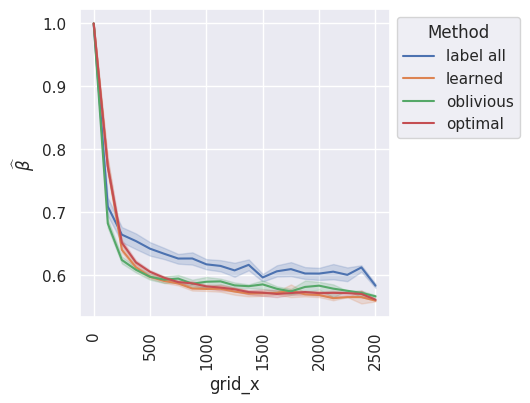

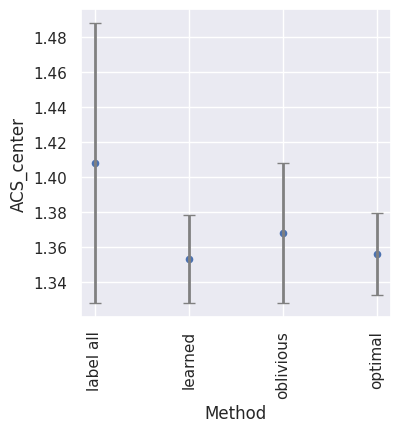

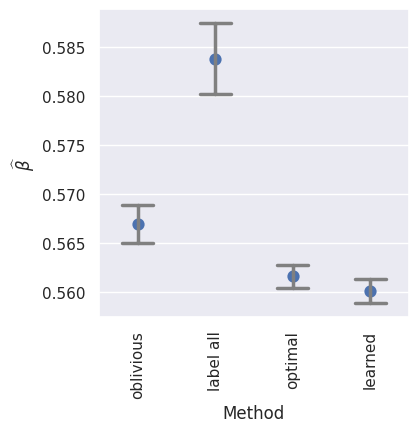

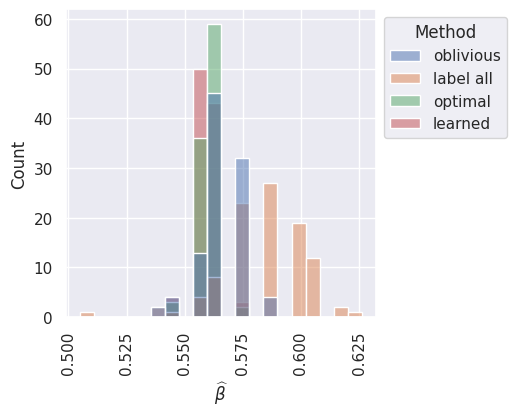

In [17]:
visualize_beta_hat(*(load_debug_results('results/simulation/default')), scores=scores, beta_star=None)

## Ablation: different target rates

In [ ]:
def load_parent_dir(path):
    import os
    import pandas as pd
    df = pd.concat([pd.read_csv(f'{path}/{subdir}/trial_results/{filename}') \
        for subdir in os.listdir(path) \
        for filename in os.listdir(f'{path}/{subdir}/trial_results')])
    return os.listdir(path), df
    
        
def visualize_q_ablation(df, points=21, start_prop=0, end_prop=1.):
    import seaborn as sns
    import matplotlib.pyplot as plt
    max_label_ct = df['label_ct'].max()
    final_df = df.sort_values('label_ct') \
                .groupby(['Method', 'target_rate', 'seed']) \
                .last() # get largest label_ct
    print(final_df.groupby(['target_rate', 'Method']).mean())
    
    
    sns.set_theme()
    
    sns.pointplot(data=final_df, hue='Method', x='target_rate', y='$\\widehat{\\beta}$')
    
    # label count vs. beta hat
    if len(set(df['label_ct'])) > 1:
        points = 21
        start, end = start_prop * max_label_ct, end_prop * max_label_ct
        x_bins = np.linspace(start, end, points)
        df['grid_x'] = x_bins[
            np.digitize(df['label_ct'].to_numpy(), x_bins, right=True)
        ]
        binned_df = df \
                    .sort_values('$\\widehat{\\beta}$') \
                    .groupby(['Method', 'grid_x', 'target_rate', 'seed']).first() \
                    .reset_index()
                        

        # fig, ax = plt.figure(figsize=(4,4), dpi=200), plt.gca()

        sns.relplot(data=binned_df,
                      x='grid_x', 
                      y='$\\widehat{\\beta}$',
                      hue='Method',
                      col='target_rate',
                      col_wrap=3,
                      kind='line'
                      # err_style='bars',
                      # errorbar=("se", 2),
                      # err_kws={"color": ".5", "linewidth": 1, 'solid_capstyle': 'round'},
                      )
        plt.xticks(rotation=90)
# dirs, df = load_parent_dir('results/coco_d/q_ablation')
# print(f'Subdirs loaded: {dirs}')
# print(f'df.columns: {df.columns}')
# visualize_q_ablation(df)

In [ ]:
# dirs, df = load_parent_dir('results/imagenet_d/q_ablation')
# print(f'Subdirs loaded: {dirs}')
# print(f'df.columns: {df.columns}')
# visualize_q_ablation(df)